<a href="https://colab.research.google.com/github/mzouros/dl_gmsa/blob/main/VehicleTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Automobile sounds were recorded through our mobile phones.
Preprocessing for each audio sound (Audacity):

1. Noise Reduction (eg bird noises, horns, chats) where possible
2. Resample to 8k
3. Stereo to Mono
4. Trim to 30sec

In [ ]:
# Upload & Unzip models to host

from google.colab import files
import zipfile

uploaded = files.upload()

path_to_zip_file = '/content/arrays.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
# Host Library installs

!sudo apt-get install portaudio19-dev python-all-dev
!pip3 install pyaudio

In [ ]:
# Imports

import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import cv2 
import statistics
import math
from IPython.display import Audio

# visualization
import plotly.offline as py
import plotly
import plotly.graph_objects as go
import seaborn as sns

# crop soundwaves/spectograms
from PIL import Image

# mel spectograms
import librosa
import librosa.display
import soundfile as sf # librosa's output

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC, SVR
from sklearn import neighbors, datasets, svm, metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, f1_score

# keras
from tensorflow import keras
import autokeras as ak
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D
from keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

# record audio
import sounddevice as sd
import scipy
from scipy.io.wavfile import write

# print all output
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
# Create Mel Spectograms

recordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/UpdatedRecordings'
augmentedRecordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/AugmentedRecordings'
melSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectograms'

for audio in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+'/'+audio, sr=8000)
  mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time')
  plt.title('Mel Spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.savefig(melSpectoPath+'/'+os.path.splitext(audio)[0]+'.png', dpi = 300)
  plt.clf()

for audio in os.listdir(augmentedRecordingsPath):
  y, sr = librosa.load(augmentedRecordingsPath+'/'+audio, sr=8000)
  mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time')
  plt.title('Mel Spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.savefig(melSpectoPath+'/'+os.path.splitext(audio)[0]+'.png', dpi = 300)
  plt.clf()

In [ ]:
# Crop axes from Mel Spectograms

for image in os.listdir(melSpectoPath):
  im = Image.open(melSpectoPath+'/'+image)
  
  # Setting the points for cropped image
  left = 224
  top = 143
  right = 1343
  bottom = 1052

  croppedImage = im.crop((left, top, right, bottom))
  croppedImage.save(melSpectoPath+'/'+image)

In [ ]:
# Create X, y arrays

melSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectograms'
maskedMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/TimeMasking'

X = []
y = []

# Mel Spectograms
for image in os.listdir(melSpectoPath):
  img = cv2.imread(melSpectoPath + '/' + image)
  resized_image = cv2.resize(img, (256, 256))

  X.append(np.asarray(resized_image))

  # get labels from image names
  partitioned_string = image.partition('_')
  label = partitioned_string[0]
  if int(label) <= 5:
    y.append(0)
  elif int(label) <= 10:
    y.append(1)
  elif int(label) <= 15:
    y.append(2)
  elif int(label) <= 20:
    y.append(3)
  elif int(label) <= 25:
    y.append(4)
  elif int(label) <= 30:
    y.append(5)
  elif int(label) <= 35:
    y.append(6)
  else:
    y.append(7)

# Filtered Mel Spectograms
for image in os.listdir(maskedMelSpectoPath):
  img = cv2.imread(maskedMelSpectoPath + '/' + image)
  resized_image = cv2.resize(img, (256, 256))

  X.append(np.asarray(resized_image))

  # get labels from image names
  partitioned_string = image.partition('_')
  label = partitioned_string[0]
  if int(label) <= 5:
    y.append(0)
  elif int(label) <= 10:
    y.append(1)
  elif int(label) <= 15:
    y.append(2)
  elif int(label) <= 20:
    y.append(3)
  elif int(label) <= 25:
    y.append(4)
  elif int(label) <= 30:
    y.append(5)
  elif int(label) <= 35:
    y.append(6)
  else:
    y.append(7)


# # Save the X, y np.arrays
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/X.npy', X)
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/y.npy', y)

In [ ]:
# Load the X, y np.arrays

# local
X = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/X.npy')
y = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/y.npy')

# machine
# X = np.load('/content/X.npy')
# y = np.load('/content/y.npy')

# Normalization for CNN
X = np.stack(X)
X = X.astype('float32')
X = X/255

# for classification only
y = to_categorical(y)
labels = 8

np.array(X).shape
np.array(y).shape

print(X.shape)
print(y.shape)


# CNN Training

X.shape
y.shape

# Within the total data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(0.8*len(X)), random_state=42)

print('Dimensions\n---')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

In [ ]:
# Autokeras (implementation of AutoML for deep learning)

# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=5)
# Feed the image classifier with training data.
clf.fit(X_train, y_train, epochs=30)


# # Predict with the best model.
predicted_y = clf.predict(X_test)
print(predicted_y)


# # Evaluate the best model with testing data.
print(clf.evaluate(X_test, y_test))

clf.fit(
    X_train,
    y_train,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test),
    epochs=30
)

# Evaluate
score = clf.evaluate(X_test, y_test, verbose=1)
print('accuracy: ',score[1])
print('loss: ',score[0])

In [ ]:
# Model configuration

# Determine shape of the data
input_dimension = (256, 256, 3)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
# inputs = np.concatenate((X_train, X_test), axis=0)
# targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # Define the model architecture
  model = Sequential()

  # # Layer 1
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_dimension, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2)) # to avoid overfitting

  # # Layer 2
  model.add(Conv2D(64, (3, 3)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.3))

  # Layer 3
  model.add(Conv2D(128, (3, 3)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))
  model.add(Flatten())

  # # Layer 4
  model.add(Dense(32, activation = 'relu'))
  # model.add(Dropout(0.5))

  # Layer 5
  model.add(Dense(labels, activation='softmax'))

  model.summary()

  opt = keras.optimizers.Adam(learning_rate=0.0001)

  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  # simple early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X_train,
                      y_train,
                      batch_size=32,
                      epochs=30,
                      verbose=1,
                      validation_data=(X_test, y_test),
                      callbacks=[es])
  

  # evaluate the model
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

  # plot loss - val loss
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

  # plot accuracy - val accuracy
  plt.plot(history.history['accuracy'], label='train_acc')
  plt.plot(history.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

  # Generate generalization metrics
  scores = model.evaluate(X_test, y_test, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
# Finalize model

# Load the X, y np.arrays

# local
X = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/X.npy')
y = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MelSpectogramArrays/y.npy')

# machine
# X = np.load('/content/X.npy')
# y = np.load('/content/y.npy')

# Normalization for CNN
X = np.stack(X)
X = X.astype('float32')
X = X/255

# for classification only
y = to_categorical(y)
labels = 8

np.array(X).shape
np.array(y).shape

print(X.shape)
print(y.shape)

# Model configuration

# Determine shape of the data
input_dimension = (512, 512, 3)


# Define the model architecture
model = Sequential()

# Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_dimension, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) # to avoid overfitting

# Layer 2
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

# Layer 3
model.add(Dense(8, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X,
                    y,
                    batch_size=16,
                    epochs=20,
                    verbose=1)

# save the model
model.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/Models/Mel')

In [ ]:
# Record & Predict

model = keras.models.load_model('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/Models/Mel')
liveRecordingPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/LiveRecordings/'

# Record audio
fs = 8000  # Sample rate
seconds = 30 # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
write(liveRecordingPath+'output.wav', fs, myrecording)  # Save as WAV file 

# Transform .wav to .png
y, sr = librosa.load(liveRecordingPath+'output.wav', sr=8000)
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.savefig(liveRecordingPath+'output.png', dpi = 300)
plt.clf()

# Crop axes
im = Image.open(liveRecordingPath+'output.png')

# Setting the points for cropped image
left = 224
top = 143
right = 1343
bottom = 1052

croppedImage = im.crop((left, top, right, bottom))
croppedImage.save(liveRecordingPath+'croppedOutput.png')

# Load Mel Spectogram
img = cv2.imread(liveRecordingPath+'croppedOutput.png')
resized_image = cv2.resize(img, (512, 512))
Xnew = array([resized_image])
ynew = np.argmax(model.predict(Xnew), axis=-1)

# Predictions
print("Predicted=%s" % (ynew[0]))

In [ ]:
# Data Augmentation
# Create Mask Mel Spectograms (filter)
# Code Author: @peisuke

import time
import random
import argparse
import sys
import os
import pathlib

import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import interpolate
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import dct,idct
from scipy.spatial.distance import pdist, cdist, squareform

recordings = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/UpdatedRecordings/'
augmentedRecordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/AugmentedRecordings/'
maskedMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/asdf/'

def makeT(cp):
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift

for recording in os.listdir(augmentedRecordingsPath):

  # create track's mel spectogram (whole song)
  time_sum = 0
  y, sr = librosa.load(augmentedRecordingsPath+recording, sr=8000)
  spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
  spec = librosa.power_to_db(spec,ref=np.max)
  for n in range(5): 
    start = time.time()
    W=40
    T=30
    F=13
    mt=2
    mf=2

    # Nframe : number of spectrum frame
    Nframe = spec.shape[1]
    # Nbin : number of spectrum freq bin
    Nbin = spec.shape[0]
    # check input length
    if Nframe < W*2+1:
        W = int(Nframe/4)
    if Nframe < T*2+1:
        T = int(Nframe/mt)
    if Nbin < F*2+1:
        F = int(Nbin/mf)

    # warping parameter initialize
    w = random.randint(-W,W)
    center = random.randint(W,Nframe-W)

    src = np.asarray([[ float(center),  1], [ float(center),  0], [ float(center),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
    dst = np.asarray([[ float(center+w),  1], [ float(center+w),  0], [ float(center+w),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
    #print(src,dst)

    # source control points
    xs, ys = src[:,0],src[:,1]
    cps = np.vstack([xs, ys]).T
    # target control points
    xt, yt = dst[:,0],dst[:,1]
    # construct TT
    TT = makeT(cps)

    # solve cx, cy (coefficients for x and y)
    xtAug = np.concatenate([xt, np.zeros(3)])
    ytAug = np.concatenate([yt, np.zeros(3)])
    cx = nl.solve(TT, xtAug) # [K+3]
    cy = nl.solve(TT, ytAug)

    # dense grid
    x = np.linspace(0, Nframe-1,Nframe)
    y = np.linspace(1,1,1)
    x, y = np.meshgrid(x, y)

    xgs, ygs = x.flatten(), y.flatten()

    gps = np.vstack([xgs, ygs]).T

    # transform
    pgLift = liftPts(gps, cps) # [N x (K+3)]
    xgt = np.dot(pgLift, cx.T)     
    spec_warped = np.zeros_like(spec)
    for f_ind in range(Nbin):
        spec_tmp = spec[f_ind,:]
        func = interpolate.interp1d(xgt, spec_tmp,fill_value="extrapolate")
        xnew = np.linspace(0, Nframe-1,Nframe)
        spec_warped[f_ind,:] = func(xnew)

    # sample mt of time mask ranges
    t = np.random.randint(T-1, size=mt)+1
    # sample mf of freq mask ranges
    f = np.random.randint(F-1, size=mf)+1
    # mask_t : time mask vector
    mask_t = np.ones((Nframe,1))
    ind = 0
    t_tmp = t.sum() + mt
    for _t in t:
        k = random.randint(ind,Nframe-t_tmp)
        mask_t[k:k+_t] = 0
        ind = k+_t+1
        t_tmp = t_tmp - (_t+1)
    mask_t[ind:] = 1

    # mask_f : freq mask vector
    mask_f = np.ones((Nbin,1))
    ind = 0
    f_tmp = f.sum() + mf
    for _f in f:
        k = random.randint(ind,Nbin-f_tmp)
        mask_f[k:k+_f] = 0
        ind = k+_f+1
        f_tmp = f_tmp - (_f+1)
    mask_f[ind:] = 1

    # calculate mean
    mean = np.mean(spec_warped)

    # make spectrum to zero mean
    spec_zero = spec_warped-mean

    spec_masked = ((spec_zero * mask_t.T) * mask_f) + mean

    end = time.time()
    time_sum += (end - start)  
  librosa.display.specshow(spec_masked, y_axis='mel', x_axis='time');
  plt.title('Mel Spectrogram');
  plt.colorbar(format='%+2.0f dB');
  plt.savefig(maskedMelSpectoPath+os.path.splitext(recording)[0]+'.png', dpi = 300)
  plt.clf()


# Crop axes from Mel Spectograms
for image in os.listdir(maskedMelSpectoPath):
  im = Image.open(maskedMelSpectoPath+'/'+image)
  
  # Setting the points for cropped image
  left = 224
  top = 143
  right = 1343
  bottom = 1052

  croppedImage = im.crop((left, top, right, bottom))
  croppedImage.save(maskedMelSpectoPath+'/'+image)

<Figure size 432x288 with 0 Axes>

In [ ]:
# MFCCs / STFTs / ZCRs Feautures Extraction:

recordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/UpdatedRecordings/'

X = []
Y = []

for recording in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+recording)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  stft = np.abs(librosa.stft(y))
  zcr = librosa.feature.zero_crossing_rate(y)

  #TODO: pitchspec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  mfcc_to_int = mfcc.astype(int)
  stft_to_int = stft.astype(int)
  
  mfcc_means = []
  stft_means = []
  ConcatList = []
  for i in range(0,40):
    mfcc_mean = statistics.mean(mfcc_to_int[i])
    mfcc_means.append(mfcc_mean)
  for i in range(0,1025):
    stft_mean = statistics.mean(stft_to_int[i])
    stft_means.append(stft_mean)

  # X.append(np.hstack((Xmfcc, Xstft, zcr[0])).ravel())
  ConcatList = list(mfcc_means) + list(stft_means) + list(zcr[0])
  X.append(ConcatList)

  partitioned_string = recording.partition('_')
  label = partitioned_string[0]

  # SVC
  if int(label) <= 5:
    Y.append(0)
  elif int(label) <= 10:
    Y.append(1)
  elif int(label) <= 15:
    Y.append(2)
  elif int(label) <= 20:
    Y.append(3)
  elif int(label) <= 25:
    Y.append(4)
  elif int(label) <= 30:
    Y.append(5)
  elif int(label) <= 35:
    Y.append(6)
  else:
    Y.append(7)

  # SVR
  # partitioned_string = recording.partition('_')
  # label = partitioned_string[0]
  # Y.append(label)


# Save the X, y np.arrays
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MFCCArrays/X.npy', X)
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MFCCArrays/y.npy', Y)      

In [ ]:
# Load the X, y np.arrays (SVC)

# local
X = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MFCCArrays/X.npy')
y = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/MFCCArrays/y.npy')

# machine 
# X = np.load('/content/X.npy')
# y = np.load('/content/y.npy')

# Standardization
# X.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(X)

# for classification only
labels = 8

# Within the total data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(0.8*len(X)), random_state=42)

print('Dimensions\n---')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

In [ ]:
# Time & Frequency Domain Features Extraction:

recordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/UpdatedRecordings/'
augmentedPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/AugmentedRecordings/'

X = []
Y = []

for recording in os.listdir(recordingsPath):
  
  # load
  y, sr = librosa.load(recordingsPath+'/'+recording, sr=8000)

  # Frequency Domain Features: 
  # Spectral Centroid
  cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  # Bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

  # Time Domain Features:
  # Root-Mean-Square Energy
  rms = librosa.feature.rms(y=y)
  # Zero-Crossing Rate
  zcr = librosa.feature.zero_crossing_rate(y)

  # # remove extra arrays
  # cent = np.array(cent).ravel()
  # spec_bw = np.array(spec_bw).ravel()
  # rms = np.array(rms).ravel()
  # zcr = np.array(zcr).ravel()
  # # calculate mean for each feature array
  # cent_sd = statistics.mean(cent)
  # spec_bw_sd = statistics.mean(spec_bw)
  # rms_sd = statistics.mean(rms)
  # zcr_sd = statistics.mean(zcr)
  # ConcatList = [cent_sd, spec_bw_sd, rms_sd, zcr_sd]


  ConcatList = list(cent) + list(spec_bw) + list(rms) + list(zcr)
  X.append(ConcatList)

  partitioned_string = recording.partition('_')
  label = partitioned_string[0]

  # SVC
  if int(label) <= 5:
    Y.append(0)
  elif int(label) <= 10:
    Y.append(1)
  elif int(label) <= 15:
    Y.append(2)
  elif int(label) <= 20:
    Y.append(3)
  elif int(label) <= 25:
    Y.append(4)
  elif int(label) <= 30:
    Y.append(5)
  elif int(label) <= 35:
    Y.append(6)
  else:
    Y.append(7)


for recording in os.listdir(augmentedPath):
  
  # load
  y, sr = librosa.load(augmentedPath+'/'+recording, sr=8000)

  # Frequency Domain Features: 
  # Spectral Centroid
  cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  # Bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

  # Time Domain Features:
  # Root-Mean-Square Energy
  rms = librosa.feature.rms(y=y)
  # Zero-Crossing Rate
  zcr = librosa.feature.zero_crossing_rate(y)

  # # remove extra arrays
  # cent = np.array(cent).ravel()
  # spec_bw = np.array(spec_bw).ravel()
  # rms = np.array(rms).ravel()
  # zcr = np.array(zcr).ravel()
  # # calculate mean for each feature array
  # cent_sd = statistics.mean(cent)
  # spec_bw_sd = statistics.mean(spec_bw)
  # rms_sd = statistics.mean(rms)
  # zcr_sd = statistics.mean(zcr)
  # ConcatList = [cent_sd, spec_bw_sd, rms_sd, zcr_sd]


  ConcatList = list(cent) + list(spec_bw) + list(rms) + list(zcr)
  X.append(ConcatList)

  partitioned_string = recording.partition('_')
  label = partitioned_string[0]

  # SVC
  if int(label) <= 5:
    Y.append(0)
  elif int(label) <= 10:
    Y.append(1)
  elif int(label) <= 15:
    Y.append(2)
  elif int(label) <= 20:
    Y.append(3)
  elif int(label) <= 25:
    Y.append(4)
  elif int(label) <= 30:
    Y.append(5)
  elif int(label) <= 35:
    Y.append(6)
  else:
    Y.append(7)

# Save the X, y np.arrays
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/TimeFrequencyDomains/X.npy', X)
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/TimeFrequencyDomains/y.npy', Y)      

In [ ]:
# Load the X, y np.arrays (SVC)

X = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/TimeFrequencyDomains/X.npy')
y = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/TimeFrequencyDomains/y.npy')

# Standardization
nsamples, nx, ny = X.shape
X = X.reshape(nsamples,nx*ny)
scaler = preprocessing.StandardScaler().fit(X)

# for classification only
labels = 8

# Within the total data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(0.8*len(X)), random_state=42)

print('Dimensions\n---')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

In [ ]:
# Train / Test Accuracy for different C values for SVC

classifiers, train_acc, test_acc = [], [], []
Cs = [0.1, 0.5, 1, 10, 100, 1000]
for c in Cs:
    classifiers.append(svm.SVC(kernel='rbf', C=c, gamma='scale'))
    classifiers[-1].fit(X_train, y_train)
    y_pred = classifiers[-1].predict(X_train)
    train_acc.append(np.count_nonzero(y_train==y_pred) / len(y_pred))
    y_pred = classifiers[-1].predict(X_test)
    test_acc.append(np.count_nonzero(y_test==y_pred) / len(y_pred))

# Visualize:
fig = go.Figure(data=[go.Scatter(x=Cs, y=train_acc, name='train accuracy',marker_size=5),
                      go.Scatter(x=Cs, y=test_acc, name='test accuracy',marker_size=5),],
                layout=go.Layout(title='Train and Validation accuracy vs model complexity',
                                           xaxis=dict(title="C",), 
                                           yaxis=dict(title="Accuracy",)))
plotly.offline.iplot(fig)

Accuracy (Polynomial Kernel):  27.88
F1 (Polynomial Kernel):  18.41
Accuracy (RBF Kernel):  26.92
F1 (RBF Kernel):  20.07


Text(0.5, 1, 'Accuracy Score: 0.27884615384615385')

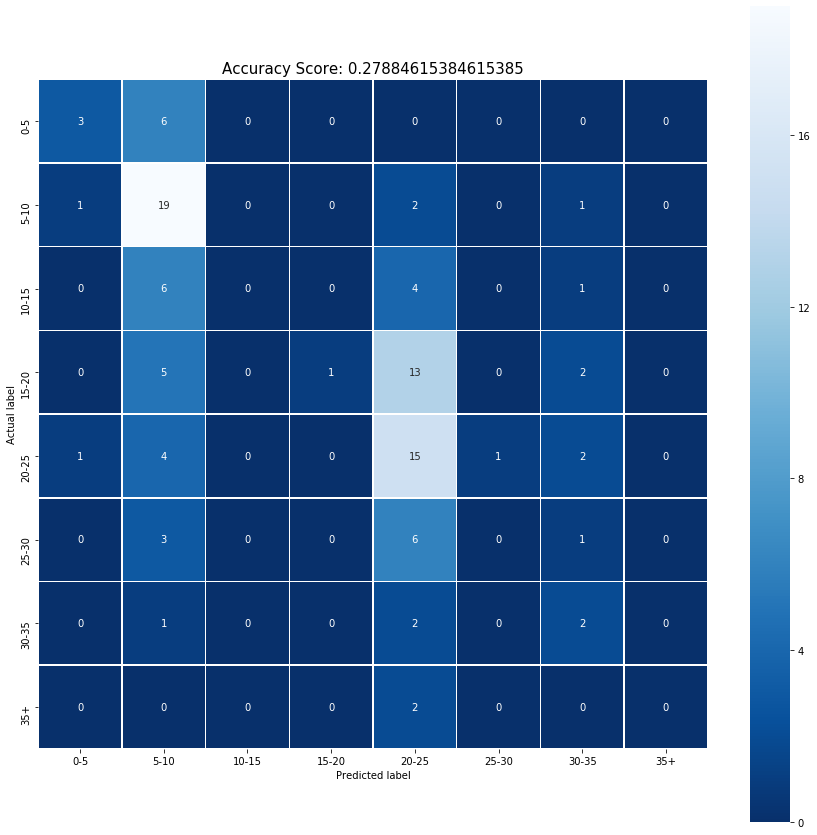

In [ ]:
# SVC

rbf = svm.SVC(kernel='rbf', C=100).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', C=100).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))


cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(15,15))
x_axis_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
y_axis_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='.0f', linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, poly_pred))
plt.title(all_sample_title,size=15)

In [ ]:
# Record & Predict

liveRecordingPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/LiveRecordings/'

# Record audio
fs = 8000  # Sample rate
seconds = 30 # Duration of recording

# myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
# sd.wait()  # Wait until recording is finished
# write(liveRecordingPath+'output.wav', fs, myrecording)  # Save as WAV file 

# Extract MFCCs/STFTs/ZCRs
# y, sr = librosa.load(liveRecordingPath+'output.wav')
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
# stft = np.abs(librosa.stft(y))
# zcr = librosa.feature.zero_crossing_rate(y)
# mfcc_to_int = mfcc.astype(int)
# stft_to_int = stft.astype(int)

# mfcc_means = []
# stft_means = []
# ConcatList = []
# for i in range(0,40):
#   mfcc_mean = statistics.mean(mfcc_to_int[i])
#   mfcc_means.append(mfcc_mean)
# for i in range(0,1025):
#   stft_mean = statistics.mean(stft_to_int[i])
#   stft_means.append(stft_mean)

# ConcatList = list(mfcc_means) + list(stft_means) + list(zcr[0])
# print(len(ConcatList))

# Extract Time & Frequency Domain Features
y, sr = librosa.load(liveRecordingPath+'/output.wav', sr=8000)
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rms = librosa.feature.rms(y=y)
zcr = librosa.feature.zero_crossing_rate(y)
ConcatList = list(cent) + list(spec_bw) + list(rms) + list(zcr)

# Load to Arrays
Xnew = array([ConcatList])
nsamples, nx, ny = Xnew.shape
Xnew = Xnew.reshape(nsamples,nx*ny)
ynew = rbf.predict(Xnew)
ynew = poly.predict(Xnew)

# Predictions
print("(rbf) Predicted=%s" % (ynew[0]))
print("(poly) Predicted=%s" % (ynew[0]))

(rbf) Predicted=1
(poly) Predicted=1


In [ ]:
# Data Augmentation (Pitch Shifting)

recordingsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/UpdatedRecordings/'
augmentedPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/3. Machine Learning in Multimedia Data/Exercises/AugmentedRecordings/'

for audio in os.listdir(recordingsPath):
  
  # load
  y, sr = librosa.load(recordingsPath+'/'+audio, sr=8000)

  # Time Stretching (not good because we want specific duration)
  # y_fast = librosa.effects.time_stretch(y, 2.0)
  # sf.write(augmentedPath+os.path.splitext(audio)[0]+'_fasttimestretch.wav', y_fast, sr)
  # y_slow = librosa.effects.time_stretch(y, 0.5)
  # sf.write(augmentedPath+os.path.splitext(audio)[0]+'_slowtimestretch.wav', y_slow, sr)

  # Pitch Shifting
  y_pitchup = librosa.effects.pitch_shift(y, sr, n_steps=4) # shift up by a major third (four steps if bins_per_octave is 12)
  sf.write(augmentedPath+os.path.splitext(audio)[0]+'_pitchshiftup.wav', y_pitchup, sr)
  y_pitchdown = librosa.effects.pitch_shift(y, sr, n_steps=-4) # shift up by a major third (four steps if bins_per_octave is 12)
  sf.write(augmentedPath+os.path.splitext(audio)[0]+'_pitchshiftdown.wav', y_pitchdown, sr)